# Import Libraries

In [12]:
# Re-implement using pure shapely + rasterio (no geopandas) to avoid array-interface issues
import warnings
import sys
import geopandas as gpd
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import orient
import pathlib
import requests
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt

from dotenv import load_dotenv
import os
warnings.filterwarnings("ignore", category=UserWarning)

## Import api key

store api in a file named ".env"

In [28]:
load_dotenv()
api_key = os.getenv("oet-api")


# Download Experimental peff

## Define Custom Functions

In [13]:
def geojson_to_lonlat_lists(
    path: str,
    include_holes: bool = False,
    enforce_ccw: bool = False,
    feature_index: int | None = None,
    *,
    simplify_tolerance: float | None = None,
    simplify_units: str = "meters",  # "meters" or "degrees"
    simplify_preserve_topology: bool = True,
):
    """
    Read a GeoJSON file and return flattened [lon, lat, lon, lat, ...] lists
    for each polygon ring (exteriors by default; holes optional).

    Parameters
    ----------
    path : str
        Path to a GeoJSON file.
    include_holes : bool
        If True, include interior rings (holes).
    enforce_ccw : bool
        If True, force exterior rings to be counterclockwise.
    feature_index : int | None
        If an int, process only that feature. If None, process all features.
    simplify_tolerance : float | None
        If provided, simplify geometry with Shapely .simplify().
        Units controlled by `simplify_units`.
    simplify_units : {"meters", "degrees"}
        Unit for `simplify_tolerance`. If "meters" (recommended), geometry is
        projected to EPSG:3857 for simplification, then returned to WGS84.
        If "degrees", simplification is done directly on WGS84 coords.
    simplify_preserve_topology : bool
        Passed to Shapely .simplify(preserve_topology=...).

    Returns
    -------
    list
        A single flat list if exactly one ring was produced;
        otherwise a list of flat lists (one per ring).
    """
    gdf = gpd.read_file(path)
    if gdf.empty:
        return []

    # Assume GeoJSON is WGS84 if undefined
    if gdf.crs is None:
        gdf = gdf.set_crs(4326)

    # Limit to one feature if requested
    if feature_index is not None:
        gdf = gdf.iloc[[feature_index]]

    # Optional simplification
    if simplify_tolerance is not None:
        if simplify_units.lower() == "meters":
            gdf_metric = gdf.to_crs(3857)
            gdf_metric["geometry"] = gdf_metric.geometry.apply(
                lambda geom: geom.simplify(simplify_tolerance, preserve_topology=simplify_preserve_topology)
                if geom and not geom.is_empty else geom
            )
            gdf = gdf_metric.to_crs(4326)
        elif simplify_units.lower() == "degrees":
            gdf_4326 = gdf.to_crs(4326)
            gdf_4326["geometry"] = gdf_4326.geometry.apply(
                lambda geom: geom.simplify(simplify_tolerance, preserve_topology=simplify_preserve_topology)
                if geom and not geom.is_empty else geom
            )
            gdf = gdf_4326
        else:
            raise ValueError("simplify_units must be 'meters' or 'degrees'.")

    def ring_to_flat_list(ring):
        x, y = ring.xy
        coords = list(zip(x, y))[:-1]  # drop duplicated closing vertex
        out = []
        for lon, lat in coords:
            out.extend([lon, lat])
        return out

    out_lists = []
    for geom in gdf.geometry:
        if geom is None or geom.is_empty:
            continue

        def handle_polygon(poly: Polygon):
            p = orient(poly, 1.0) if enforce_ccw else poly
            out_lists.append(ring_to_flat_list(p.exterior))
            if include_holes:
                for hole in p.interiors:
                    out_lists.append(ring_to_flat_list(hole))

        if isinstance(geom, Polygon):
            handle_polygon(geom)
        elif isinstance(geom, MultiPolygon):
            for p in geom.geoms:
                if p and not p.is_empty:
                    handle_polygon(p)
        else:
            # Ignore non-polygonal features
            continue

    return out_lists[0] if len(out_lists) == 1 else out_lists


In [2]:
pou = gpd.read_file("pou_classified.gpkg")


In [ ]:
# All features, simplify to ~10 m, exteriors only, force CCW
lists_out = geojson_to_lonlat_lists(
    "my_polys.geojson",
    include_holes=False,
    enforce_ccw=True,
    simplify_tolerance=10,
    simplify_units="meters",
)

# Single feature (index 0), include holes, simplify in degrees
single_out = geojson_to_lonlat_lists(
    "my_polys.geojson",
    feature_index=0,
    include_holes=True,
    simplify_tolerance=0.0001,  # ~11 m at Equator
    simplify_units="degrees",
)


In [ ]:
# set your API key before making the request
header = {"Authorization": api_key}

data = {}

ind = 0
for feat in pou.itertuples():
    if ind >18:
        lonlat_lists = geojson_to_lonlat_lists(
            path="pou_classified.gpkg",
            feature_index=ind,
            include_holes=False,
            enforce_ccw=True,
            simplify_tolerance=10,
            simplify_units="meters",
        )
        
        print(f"Feature {feat.Index} lonlat lists: {lonlat_lists}")
        args = {
            "date_range": [
                "2023-01-01",
                "2024-12-31"
            ],
            "file_format": "json",
            "geometry": lonlat_lists,
            "interval": "monthly",
            "model": "Ensemble",
            "reference_et": "gridMET",
            "spinup": 12,
            "units": "mm"
            }
        request_url = "https://utah.openet-api.org/"
        # query the api 
        resp = requests.post(
            headers=header,
            json=args,
            url=request_url + "experimental/peff/polygon"
        )

        print(resp.json())
        data[feat.Index] = resp.json()
    ind += 1

Feature 19 lonlat lists: [-113.0191140633905, 38.36383484402477, -113.01865703226709, 38.36266220994505, -113.01771131408152, 38.36168747558936, -113.01639459822701, 38.36103192499685, -113.01497423862047, 38.36077789969403, -113.01342907755105, 38.36080316624372, -113.0124720603936, 38.36105542165094, -113.01177232794063, 38.36137350869072, -113.01064060167917, 38.36227463814645, -113.00997952778617, 38.363430116593165, -113.00998366916515, 38.36427506260172, -113.01908514568053, 38.364416021886576]
[{'time': '2023-01-01', 'peff': 50.628, 'etaw': 0.0, 'et': 1.441, 'pr': 50.86}, {'time': '2023-02-01', 'peff': 34.275, 'etaw': 0.0, 'et': 14.365, 'pr': 34.371}, {'time': '2023-03-01', 'peff': 48.593, 'etaw': 0.0, 'et': 53.21, 'pr': 48.593}, {'time': '2023-04-01', 'peff': 17.981, 'etaw': 0.049, 'et': 78.337, 'pr': 17.981}, {'time': '2023-05-01', 'peff': 15.392, 'etaw': 104.29, 'et': 165.44, 'pr': 15.392}, {'time': '2023-06-01', 'peff': 10.725, 'etaw': 152.839, 'et': 163.669, 'pr': 10.725}, 

KeyboardInterrupt: 

In [48]:
new_data = {}
for key,value in data.items():
    print(value[0].values())
    print(value[0].keys())
    new_data[key] = pd.DataFrame(list(value[0].values()), index=list(value[0].keys()))


dict_values(['2023-01-01', 50.628, 0.0, 1.441, 50.86])
dict_keys(['time', 'peff', 'etaw', 'et', 'pr'])
dict_values(['2023-01-01', 49.34, 0.0, 2.912, 50.645])
dict_keys(['time', 'peff', 'etaw', 'et', 'pr'])
dict_values(['2023-01-01', 50.704, 0.0, 4.991, 50.936])
dict_keys(['time', 'peff', 'etaw', 'et', 'pr'])
dict_values(['2023-01-01', 50.148, 0.0, 10.001, 50.364])
dict_keys(['time', 'peff', 'etaw', 'et', 'pr'])
dict_values(['2023-01-01', 49.841, 0.0, 4.37, 49.841])
dict_keys(['time', 'peff', 'etaw', 'et', 'pr'])
dict_values(['2023-01-01', 50.302, 0.0, 5.055, 50.525])
dict_keys(['time', 'peff', 'etaw', 'et', 'pr'])


In [49]:
peff = pd.concat(new_data).unstack(-1).droplevel(0,axis=1)
peff.index.name = "obid"

In [ ]:
peff.to_csv("pou_peff_2023_2024_3.csv")

# Download Timeseries

In [78]:
gdf = gpd.read_file("pou_ids.gpkg")
oetgdf = gdf.dropna(subset=['field_id']).set_index('field_id')
oetgdf.index = oetgdf.index.astype(int)
oet_list = oetgdf.index.astype('int').astype("str").tolist()
areas = np.round(oetgdf.geometry.area * 0.000247105,1).to_dict()
grpnb = oetgdf['GROUP_NUMB'].to_dict()

In [35]:
# set your API key before making the request
header = {"Authorization": api_key}


args = {
    "date_range": [
        "2022-01-01",
        "2025-06-01"
    ],
    "interval": "monthly",
    "field_ids":oet_list,
    "models": ["ensemble","eemetric","ssebop"],
    "variables":["ET","PR"],
    "file_format": "json",
    }
request_url = "https://utah.openet-api.org/"
# query the api 
resp = requests.post(
    headers=header,
    json=args,
    url=request_url + "geodatabase/timeseries"
)


In [79]:
import gzip
# unzip the data
data = eval(gzip.decompress(resp.content).decode())
db_oet = pd.DataFrame(data)
db_oet['time'] = pd.to_datetime(db_oet['time'])
db_oet['field_id'] = db_oet['field_id'].astype('int')
db_oet['et_acft'] = db_oet['value_mm'] *  db_oet['field_id'].map(areas)* 0.00328084
db_oet = db_oet.set_index(['field_id','time','collection'])
db_oet.drop(['value_mm'],axis=1,inplace=True)
db_oet = db_oet.unstack('collection').droplevel(0,axis=1)
db_oet['GROUP_NUM'] = db_oet.index.get_level_values(0).map(grpnb)

In [81]:
# assume df has a MultiIndex with names ("fieldid", "date")
fid = db_oet["GROUP_NUM"]
dt  = db_oet.index.get_level_values('time')

# keep only March (3) through November (11)
mask = (dt.month >= 3) & (dt.month <= 11)
df_mn = db_oet[mask]

# group by fieldid and calendar year
out = (df_mn
       .groupby([fid[mask], dt[mask].year]).sum())


out.index.names = ["GROUP_NUM", "year"]


In [84]:
out['eff_et_ens'] = out['ensemble_et'] - out['gridmet_pr']
out['eff_et_eem'] = out['eemetric_et'] - out['gridmet_pr']
out['eff_et_ens'] = out['ssebop_et'] - out['gridmet_pr']
ef_df = out['eff_et_ens'].unstack(level=-1)
ef_df.columns = [f'efet_{col}' for col in ef_df.columns]
ef_df = ef_df.round(1)

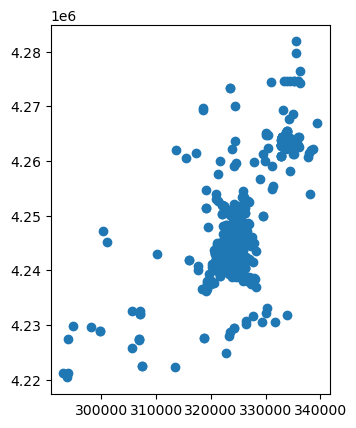

In [88]:
wells = gpd.read_file("Wells_w_Info.shp")
wells.plot()

wells_efet = pd.merge(wells,ef_df.reset_index(),left_on='GROUP_NUMB', right_on='GROUP_NUM')

well_counts = wells_efet.groupby("GROUP_NUMB").size().reset_index(name="well_count")

for col in wells_efet.columns:
    if "etet" in col:
        wells_efet[col] = wells_efet[col] / well_counts

In [89]:
wells_efet.to_file('wells_w_efet.gpkg')